In [1]:
import websocket
import json
import time
import threading
import uuid
import pandas as pd
from datetime import datetime
import logging

class TradingViewDataFetcher:
    def __init__(self, log_level=logging.WARNING):
        """
        Initialize the TradingView data fetcher with configurable logging.
        
        Args:
            log_level: Logging level (default: WARNING to suppress info messages)
        """
        logging.basicConfig(level=log_level, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)
        
        # Default WebSocket URL (can be changed if needed)
        self.ws_url = "wss://prodata.tradingview.com/socket.io/websocket"
        
        # Default headers
        self.headers = {
            "Origin": "https://www.tradingview.com",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

    def fetch_data(self, symbol, exchange="NASDAQ", interval="D", num_bars=100, timeout=20, alt_urls=None):
        """
        Fetch historical price data from TradingView.
        
        Args:
            symbol: Trading symbol (e.g., "AAPL")
            exchange: Exchange name (e.g., "NASDAQ")
            interval: Time interval (e.g., "D" for daily, "W" for weekly, "M" for monthly, 
                     or "1" for 1 minute, "5" for 5 minutes, etc.)
            num_bars: Number of bars to request
            timeout: Maximum time to wait for data in seconds
            alt_urls: List of alternative WebSocket URLs to try if the primary fails
            
        Returns:
            pandas.DataFrame: DataFrame containing OHLCV data
        """
        urls_to_try = [self.ws_url]
        if alt_urls:
            urls_to_try.extend(alt_urls)
        
        for url in urls_to_try:
            self.logger.info(f"Trying WebSocket URL: {url}")
            
            # Reset state for each attempt
            self.session_id = f"qs_{uuid.uuid4().hex[:12]}"
            self.chart_session = f"cs_{uuid.uuid4().hex[:12]}"
            self.received_data = []
            self.error_occurred = False
            
            # Create and start WebSocket
            websocket.enableTrace(False)  # Set to True for verbose WebSocket logs
            ws = websocket.WebSocketApp(
                url,
                header=[f"{k}: {v}" for k, v in self.headers.items()],
                on_open=self._on_open(symbol, exchange, interval, num_bars),
                on_message=self._on_message,
                on_error=self._on_error,
                on_close=self._on_close
            )
            
            wst = threading.Thread(target=ws.run_forever)
            wst.daemon = True
            wst.start()
            
            try:
                # Wait for data
                start_time = time.time()
                while time.time() - start_time < timeout:
                    if self.error_occurred:
                        self.logger.error("Connection error detected, trying next URL if available")
                        break
                    
                    if len(self.received_data) >= num_bars/2:
                        self.logger.info(f"Received sufficient data: {len(self.received_data)} bars")
                        break
                        
                    time.sleep(0.5)
                
                # If we have data, process and return it
                if self.received_data:
                    ws.close()
                    return self._process_data()
                
            except KeyboardInterrupt:
                self.logger.info("Interrupted by user")
            finally:
                ws.close()
        
        # If we get here, all URLs failed
        self.logger.error("Failed to retrieve data from all WebSocket URLs")
        return None

    def _process_data(self):
        """Process the received data into a DataFrame."""
        df = pd.DataFrame(self.received_data)
        if not df.empty:
            df['Date'] = pd.to_datetime(df['Date'], unit='s')
            df = df.sort_values('Date')
            #df.set_index('Date', inplace=True)
            return df
        return None

    def _on_open(self, symbol, exchange, interval, num_bars):
        """Prepare the on_open callback with the required parameters."""
        def on_open_callback(ws):
            self.logger.info("WebSocket connection established")
            
            def run():
                try:
                    self._send_message(ws, "set_auth_token", ["unauthorized_user_token"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_session", [self.chart_session, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "switch_timezone", [self.chart_session, "Etc/UTC"])
                    time.sleep(0.2)
                    
                    full_symbol = f"{exchange}:{symbol}"
                    symbol_payload = json.dumps({"symbol": full_symbol, "adjustment": "splits"})
                    self._send_message(ws, "resolve_symbol", [self.chart_session, "symbol_1", f"={symbol_payload}"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "create_series", [self.chart_session, "s1", "s1", "symbol_1", interval, num_bars, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_study", [self.chart_session, "st1", "st1", "sds_1", full_symbol, interval, num_bars, ""])
                    
                    self.logger.info(f"Requested {num_bars} {interval} bars for {full_symbol}")
                except Exception as e:
                    self.logger.error(f"Error in initialization sequence: {e}")
            
            thread = threading.Thread(target=run)
            thread.daemon = True
            thread.start()
        
        return on_open_callback

    def _send_message(self, ws, method, params):
        """Send a properly formatted message to TradingView WebSocket."""
        try:
            data = json.dumps({"m": method, "p": params})
            message = f"~m~{len(data)}~m~{data}"
            ws.send(message)
            self.logger.debug(f"Sent: {method} - {params[:50]}{'...' if len(str(params)) > 50 else ''}")
        except Exception as e:
            self.logger.error(f"Error sending message {method}: {e}")

    def _on_message(self, ws, message):
        """Handle incoming WebSocket messages."""
        if message == "~h~":
            self.logger.debug("Received heartbeat, sending pong")
            ws.send("~h~")
            return
        
        if not message.startswith("~m~"):
            return
        
        try:
            msg_parts = message.split("~m~")
            for i in range(0, len(msg_parts)):
                if msg_parts[i] and msg_parts[i].isdigit() and i + 1 < len(msg_parts):
                    content = msg_parts[i+1]
                    if content and content.startswith("{"):
                        try:
                            data = json.loads(content)
                            
                            if isinstance(data, dict) and data.get("m") == "timescale_update":
                                self.logger.debug("Found timescale_update message")
                                payload = data.get("p", [])
                                if len(payload) > 1 and isinstance(payload[1], dict):
                                    for series_id, series_data in payload[1].items():
                                        if "s" in series_data and isinstance(series_data["s"], list):
                                            bars_count = len(series_data["s"])
                                            self.logger.debug(f"Found {bars_count} price bars")
                                            
                                            for bar in series_data["s"]:
                                                if "v" in bar and len(bar["v"]) >= 5:
                                                    ts, o, h, l, c = bar["v"][:5]
                                                    volume = bar["v"][5] if len(bar["v"]) > 5 else None
                                                    self.received_data.append({
                                                        "Date": ts,
                                                        "Open": o,
                                                        "High": h,
                                                        "Low": l,
                                                        "Close": c,
                                                        "Volume": volume
                                                    })
                        except json.JSONDecodeError:
                            self.logger.debug(f"Failed to parse JSON: {content[:50]}...")
        except Exception as e:
            self.logger.error(f"Error processing message: {e}")

    def _on_error(self, ws, error):
        """Handle WebSocket errors."""
        self.error_occurred = True
        self.logger.error(f"WebSocket error: {error}")

    def _on_close(self, ws, close_status_code, close_msg):
        """Handle WebSocket connection close."""
        self.logger.debug(f"WebSocket closed: {close_status_code} - {close_msg}")


# Example usage
def get_data(symbol, exchange="NASDAQ", interval="D", bars=5000, log_level=logging.WARNING):
    """
    Simple function to fetch data from TradingView.
    
    Args:
        symbol: Trading symbol (e.g., "AAPL")
        exchange: Exchange name (default: "NASDAQ")
        interval: Time interval (default: "D" for daily)
        bars: Number of bars to request (default: 5000)
        log_level: Logging level (default: WARNING - minimal output)
    
    Returns:
        pandas.DataFrame: DataFrame with OHLCV data or None if failure
    """
    fetcher = TradingViewDataFetcher(log_level=log_level)
    
    # Alternative URLs to try if the primary fails
    alt_urls = [
        "wss://data.tradingview.com/socket.io/websocket",
        "wss://s.tradingview.com/socket.io/websocket"
    ]
    
    return fetcher.fetch_data(
        symbol=symbol,
        exchange=exchange,
        interval=interval,
        num_bars=bars,
        alt_urls=alt_urls
    )
import re 





In [2]:
import pandas as pd

# This CSV contains only the tickers, one per row, no header
url = "https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main/nasdaq/nasdaq_tickers.txt"

# Read as a single-column DataFrame
nasdaq_tickers_df = pd.read_csv(url, names=['Ticker'])

# Display the first 10 tickers as a table
# Randomly select 10 tickers from the DataFrame
sampled_tickers_df = nasdaq_tickers_df.sample(n=5, random_state=40)

stocklist = sampled_tickers_df['Ticker'].tolist()


In [3]:
N_BARS = 10
expiries = 1
strikes = 1 
stocklist = stocklist = sampled_tickers_df['Ticker'].tolist()

In [4]:
import yfinance as yf
import pandas as pd
import re

def yahoo_to_tradingview(yahoo_symbol):
    """
    Convert Yahoo Finance option contract symbol to TradingView format,
    ensuring one decimal place (.0 or .5) for the strike.
    Example: 'AAPL250718C00190000' -> 'AAPL250718C190.0'
    """
    match = re.match(r'^([A-Z]+)(\d{6})([CP])(\d{8})$', yahoo_symbol)
    if not match:
        return None
    underlying, yymmdd, cp, strike_raw = match.groups()
    strike = int(strike_raw) / 1000
    # Format to always have one decimal place
    strike_str = f"{strike:.1f}"
    return f"{underlying}{yymmdd}{cp}{strike_str}"

  # Modify as needed
all_options = pd.DataFrame()

for symbol in stocklist:
    print(f"Fetching options for {symbol}")
    ticker = yf.Ticker(symbol)
    try:
        exchange = ticker.info.get('exchange', 'N/A')
    except Exception as e:
        print(f"Could not fetch exchange info for {symbol}: {e}")
        exchange = 'N/A'
    # Get current stock price
    try:
        # Use 'regularMarketPrice' for real-time price if available
        current_price = ticker.info.get('regularMarketPrice')
        if current_price is None:
            # Fallback: use last closing price
            current_price = ticker.history(period='1d')['Close'].iloc[-1]
    except Exception as e:
        print(f"Could not fetch current price for {symbol}: {e}")
        continue
    expirations = ticker.options[:expiries]  # Take only the 3 nearest expiries
    for exp_date in expirations:
        try:
            opt_chain = ticker.option_chain(exp_date)
            options_list = []
            for opt_df, opt_type in [(opt_chain.calls, 'call'), (opt_chain.puts, 'put')]:
                opt_df = opt_df.copy()
                opt_df['optionType'] = opt_type
                # Find 5 strikes closest to current price
                opt_df['strike_diff'] = (opt_df['strike'] - current_price).abs()
                opt_df = opt_df.nsmallest(strikes, 'strike_diff')
                options_list.append(opt_df)
            options = pd.concat(options_list, ignore_index=True)
            options['expirationDate'] = exp_date
            options['symbol'] = symbol
            options['exchange'] = exchange
            options['tradingview_symbol'] = options['contractSymbol'].apply(yahoo_to_tradingview)
            all_options = pd.concat([all_options, options], ignore_index=True)
        except Exception as e:
            print(f"Failed to fetch options for {symbol} {exp_date}: {e}")

#all_options = all_options.tail(3)
# all_options.to_csv("options_nearest_3_expiries_5_strikes.csv", index=False)  # Optional: save to CSV


Fetching options for GDEN
Fetching options for VERB
Fetching options for PRCH
Fetching options for RILYP
Fetching options for ARAY


In [5]:
all_options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,strike_diff,expirationDate,symbol,exchange,tradingview_symbol
0,GDEN250718C00025000,2025-06-24 13:40:48+00:00,25.0,4.91,5.00,7.80,0.00,0.000000,3.0,0,1.186528,True,REGULAR,USD,call,5.67,2025-07-18,GDEN,NGM,GDEN250718C25.0
1,GDEN250718P00035000,2025-06-24 13:40:48+00:00,35.0,5.37,3.60,6.30,0.00,0.000000,3.0,0,0.798830,True,REGULAR,USD,put,4.33,2025-07-18,GDEN,NGM,GDEN250718P35.0
2,PRCH250718C00012500,2025-07-03 16:12:10+00:00,12.5,0.70,0.55,0.80,-0.08,-10.256408,104.0,2347,0.779299,False,REGULAR,USD,call,0.22,2025-07-18,PRCH,NCM,PRCH250718C12.5
3,PRCH250718P00012500,2025-07-02 17:26:22+00:00,12.5,0.95,0.65,0.95,0.00,0.000000,2.0,4015,0.683597,True,REGULAR,USD,put,0.22,2025-07-18,PRCH,NCM,PRCH250718P12.5
4,ARAY250718C00001000,2025-07-01 18:27:49+00:00,1.0,0.38,0.35,0.65,0.00,0.000000,10.0,14,2.406254,True,REGULAR,USD,call,0.42,2025-07-18,ARAY,NMS,ARAY250718C1.0
5,ARAY250718P00001000,2025-07-01 18:27:49+00:00,1.0,0.03,0.00,0.05,0.00,0.000000,10.0,0,1.562502,False,REGULAR,USD,put,0.42,2025-07-18,ARAY,NMS,ARAY250718P1.0


In [6]:
import logging
import pandas as pd

# ... (your code for building all_options with 'tradingview_symbol') ...

def get_data(symbol, exchange="OPRA", interval="D", bars=3):
    """
    Simple function to fetch data from TradingView.
    """
    fetcher = TradingViewDataFetcher()
    alt_urls = [
        "wss://data.tradingview.com/socket.io/websocket",
        "wss://s.tradingview.com/socket.io/websocket"
    ]
    return fetcher.fetch_data(
        symbol=symbol,
        exchange=exchange,
        interval=interval,
        num_bars=bars,
        alt_urls=alt_urls
    )


all_options['tv_ohlcv_n'] = None

for idx, row in all_options.iterrows():
    tv_symbol = row['tradingview_symbol']
    try:
        ohlcv_df = get_data(tv_symbol, exchange="OPRA", interval="D", bars=N_BARS)
        if ohlcv_df is not None and not ohlcv_df.empty:
            all_options.at[idx, 'tv_ohlcv_n'] = ohlcv_df.tail(N_BARS)
        else:
            all_options.at[idx, 'tv_ohlcv_n'] = None
    except Exception as e:
        print(f"Failed to fetch TradingView data for {tv_symbol}: {e}")
        all_options.at[idx, 'tv_ohlcv_n'] = None

# Generate labels: [0, -1, -2, ..., -(N_BARS-1)]
labels = [0] + [-(i) for i in range(1, N_BARS)]

rows = []
for idx, row in all_options.iterrows():
    symbol = row['tradingview_symbol']
    ohlcv = row['tv_ohlcv_n']
    data = {'tradingview_symbol': symbol}
    if ohlcv is not None and not ohlcv.empty:
        ohlcv = ohlcv.tail(N_BARS).reset_index(drop=True)
        # Loop over bars and labels
        for i, label in zip(range(N_BARS-1, -1, -1), labels):
            if i < len(ohlcv):
                bar = ohlcv.iloc[i]
                for col in ['Open', 'Close', 'Volume']:
                    data[f'{col}_{label}'] = bar[col] if col in bar else None
            else:
                for col in ['Open', 'Close', 'Volume']:
                    data[f'{col}_{label}'] = None
    else:
        for label in labels:
            for col in ['Open', 'Close', 'Volume']:
                data[f'{col}_{label}'] = None
    rows.append(data)

option_bars_df = pd.DataFrame(rows)

# Display a sample of the new DataFrame
print(option_bars_df.head())


2025-07-04 14:38:32,880 - ERROR - WebSocket error: Handshake status 404 Not Found -+-+- {'content-type': 'text/html; charset=utf-8', 'content-length': '129422', 'connection': 'close', 'date': 'Fri, 04 Jul 2025 18:38:32 GMT', 'vary': 'Cookie', 'expires': 'Fri, 04 Jul 2025 18:40:32 GMT', 'cache-control': 'max-age=120', 'content-security-policy': "base-uri 'none'; script-src https://static.tradingview.com/static/ blob: https://*.ampproject.org/ https://*.paypal.com/ https://platform.twitter.com https://platform.x.com https://songbird.cardinalcommerce.com/edge/v1/ https://checkout.razorpay.com/ https://*.checkout.com/ 'nonce-EhHzAFIwOui5swVPVeay3Q=='; default-src 'self' https: data: blob: wss: 'unsafe-inline'; object-src 'none'", 'x-frame-options': 'DENY', 'referrer-policy': 'origin-when-cross-origin', 'server': 'tv', 'strict-transport-security': 'max-age=63072000; includeSubDomains; preload', 'x-cache': 'Error from cloudfront', 'via': '1.1 e2aea636b5bbfa67100e8bdb9eda1cf6.cloudfront.net (

  tradingview_symbol  Open_0  Close_0  Volume_0  Open_-1  Close_-1  Volume_-1  \
0    GDEN250718C25.0     NaN      NaN       NaN      NaN       NaN        NaN   
1    GDEN250718P35.0     NaN      NaN       NaN      NaN       NaN        NaN   
2    PRCH250718C12.5     NaN      NaN       NaN      NaN       NaN        NaN   
3    PRCH250718P12.5    0.95     0.95       2.0     0.95       1.1        5.0   
4     ARAY250718C1.0     NaN      NaN       NaN      NaN       NaN        NaN   

   Open_-2  Close_-2  Volume_-2  ...  Volume_-6  Open_-7  Close_-7  Volume_-7  \
0      NaN       NaN        NaN  ...        NaN     4.92      4.91        3.0   
1      NaN       NaN        NaN  ...        NaN     5.37      5.37        3.0   
2      NaN       NaN        NaN  ...        NaN      NaN       NaN        NaN   
3     1.07      1.24        2.0  ...        2.0     1.70      1.90      501.0   
4      NaN       NaN        NaN  ...        1.0     0.25      0.25        1.0   

   Open_-8  Close_-8  Volu

In [7]:
import logging
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime
import yfinance as yf

def black_scholes_price(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

def implied_volatility(price, S, K, T, r, option_type):
    def objective(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - price
    try:
        return brentq(objective, 1e-6, 5)
    except:
        return np.nan

def black_scholes_greeks(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        delta = norm.cdf(d1)
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 - r * K * np.exp(-r * T) * norm.cdf(d2)) / 365
    else:
        delta = -norm.cdf(-d1)
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 + r * K * np.exp(-r * T) * norm.cdf(-d2)) / 365
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100
    return delta, gamma, theta, vega

# Dynamically generate labels: [0, -1, -2, ..., -(N_BARS-1)]

labels = [0] + [-(i) for i in range(1, N_BARS)]

rows = []
risk_free_rate = 0.05  # Example: 5% risk-free rate, adjust as needed

for idx, row in all_options.iterrows():
    symbol = row['tradingview_symbol']
    ohlcv = row['tv_ohlcv_n']
    option_type = row['optionType']
    strike = row['strike']
    expiry = row['expirationDate']
    bid = row.get('bid', np.nan)
    ask = row.get('ask', np.nan)
    open_interest = row.get('openInterest', np.nan)
    underlying = row['symbol']

    # Use mid price for IV calculation if possible
    if not np.isnan(bid) and not np.isnan(ask):
        price = (bid + ask) / 2
    elif not np.isnan(bid):
        price = bid
    elif not np.isnan(ask):
        price = ask
    else:
        price = np.nan

    # --- Add underlying stock open and low for each of the last N_BARS days ---
    stock_open_low_dict = {}
    stock_close_dict = {}
    S = np.nan  # Underlying price for Greeks/IV
    try:
        stock_hist = yf.Ticker(underlying).history(period=f"{N_BARS+10}d", interval="1d")  # extra days for non-trading days
        stock_hist = stock_hist.dropna(subset=['Open', 'Low', 'Close'])
        stock_hist = stock_hist.tail(N_BARS).reset_index(drop=True)
        for i, label in zip(range(N_BARS-1, -1, -1), labels):
            if i < len(stock_hist):
                stock_open_low_dict[f'stock_open_{label}'] = stock_hist.loc[i, 'Open']
                stock_open_low_dict[f'stock_low_{label}'] = stock_hist.loc[i, 'Low']
                stock_close_dict[label] = stock_hist.loc[i, 'Close']
            else:
                stock_open_low_dict[f'stock_open_{label}'] = None
                stock_open_low_dict[f'stock_low_{label}'] = None
                stock_close_dict[label] = None
        # Use the -1 label's close as S (yesterday's close)
        S = stock_close_dict.get(-1, np.nan)
    except Exception as e:
        for label in labels:
            stock_open_low_dict[f'stock_open_{label}'] = None
            stock_open_low_dict[f'stock_low_{label}'] = None
            stock_close_dict[label] = None

    # Calculate time to expiry in years
    try:
        expiry_dt = pd.to_datetime(expiry)
        today = pd.Timestamp(datetime.utcnow().date())
        T = (expiry_dt - today).days / 365.0
        if T <= 0:
            T = 1/365  # 1 day minimum to avoid div by zero
    except Exception as e:
        T = np.nan

    # Calculate IV and Greeks using S = close_-1 (yesterday's close)
    if not np.isnan(price) and not np.isnan(S) and not np.isnan(strike) and not np.isnan(T):
        try:
            iv = implied_volatility(price, S, strike, T, risk_free_rate, option_type)
        except Exception as e:
            iv = np.nan
        try:
            if not np.isnan(iv):
                delta, gamma, theta, vega = black_scholes_greeks(S, strike, T, risk_free_rate, iv, option_type)
            else:
                delta, gamma, theta, vega = [np.nan]*4
        except Exception as e:
            delta, gamma, theta, vega = [np.nan]*4
    else:
        iv, delta, gamma, theta, vega = [np.nan]*5

    # Extract OHLCV bars: label as 0, -1, -2, ..., -(N_BARS-1)
    ohlcv_dict = {}
    if ohlcv is not None and not ohlcv.empty:
        ohlcv.columns = [col.lower() for col in ohlcv.columns]
        ohlcv = ohlcv.tail(N_BARS).reset_index(drop=True)
        for i, label in zip(range(N_BARS-1, -1, -1), labels):
            if i < len(ohlcv):
                bar = ohlcv.iloc[i]
                for col in ['open', 'close', 'volume']:
                    ohlcv_dict[f'{col}_{label}'] = bar[col] if col in bar else None
            else:
                for col in ['open', 'close', 'volume']:
                    ohlcv_dict[f'{col}_{label}'] = None
    else:
        for label in labels:
            for col in ['open', 'close', 'volume']:
                ohlcv_dict[f'{col}_{label}'] = None

    data = {
        'tradingview_symbol': symbol,
        'bid': bid,
        'ask': ask,
        'openInterest': open_interest,
        'implied_volatility': iv,
        'delta': delta,
        'gamma': gamma,
        'theta': theta,
        'vega': vega
    }
    data.update(ohlcv_dict)
    data.update(stock_open_low_dict)
    rows.append(data)

option_bars_df = pd.DataFrame(rows)

# Display a sample of the new DataFrame
option_bars_df



/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_58375/35165180.py:97: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = pd.Timestamp(datetime.utcnow().date())
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_58375/35165180.py:97: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = pd.Timestamp(datetime.utcnow().date())
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_58375/35165180.py:97: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = pd.Timestamp(datetime.utcnow().date())
/

,tradingview_symbol,bid,ask,openInterest,implied_volatility,delta,gamma,theta,vega,open_0,...,volume_-1,open_-2,close_-2,volume_-2,stock_open_0,stock_low_0,stock_open_-1,stock_low_-1,stock_open_-2,stock_low_-2
0,GDEN250718C25.0,5.00,7.80,0,1.186154,0.843401,0.033639,-0.063776,0.014424,4.92,...,1.0,3.09,3.15,2.0,30.889999,30.540001,29.50,29.50,29.309999,29.309999
1,GDEN250718P35.0,3.60,6.30,0,0.868352,-0.750000,0.060865,-0.055422,0.019106,5.37,...,1.0,6.94,6.90,2.0,30.889999,30.540001,29.50,29.50,29.309999,29.309999
2,PRCH250718C12.5,0.55,0.80,2347,0.712412,0.519549,0.229572,-0.025493,0.009708,NaN,...,NaN,NaN,NaN,NaN,12.465000,12.020000,12.07,11.89,11.820000,11.740000
3,PRCH250718P12.5,0.65,0.95,4015,0.804065,-0.475934,0.203278,-0.026940,0.009702,0.95,...,5.0,1.07,1.24,2.0,12.465000,12.020000,12.07,11.89,11.820000,11.740000
4,ARAY250718C1.0,0.35,0.65,14,2.827242,0.809225,0.353464,-0.007563,0.000741,0.44,...,75.0,0.23,0.23,1.0,1.410000,1.400000,1.35,1.35,1.360000,1.340000
5,ARAY250718P1.0,0.00,0.05,0,1.554334,-0.107437,0.436917,-0.002770,0.000503,0.04,...,50.0,0.05,0.05,1.0,1.410000,1.400000,1.35,1.35,1.360000,1.340000


In [8]:
import pandas as pd

# Set option to display all columns
pd.set_option('display.max_columns', None)

# Now print your DataFrame or its columns
print(option_bars_df.head())  # prints all columns in the first 5 rows

# Or just print the list of all column names
print(option_bars_df.columns.tolist())


  tradingview_symbol   bid   ask  openInterest  implied_volatility     delta  \
0    GDEN250718C25.0  5.00  7.80             0            1.186154  0.843401   
1    GDEN250718P35.0  3.60  6.30             0            0.868352 -0.750000   
2    PRCH250718C12.5  0.55  0.80          2347            0.712412  0.519549   
3    PRCH250718P12.5  0.65  0.95          4015            0.804065 -0.475934   
4     ARAY250718C1.0  0.35  0.65            14            2.827242  0.809225   

      gamma     theta      vega  open_0  close_0  volume_0  open_-1  close_-1  \
0  0.033639 -0.063776  0.014424    4.92     4.91       3.0     4.49      4.49   
1  0.060865 -0.055422  0.019106    5.37     5.37       3.0     5.68      5.68   
2  0.229572 -0.025493  0.009708     NaN      NaN       NaN      NaN       NaN   
3  0.203278 -0.026940  0.009702    0.95     0.95       2.0     0.95      1.10   
4  0.353464 -0.007563  0.000741    0.44     0.38      10.0     0.37      0.35   

   volume_-1  open_-2  close_-2 

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create class: 1 if close_0 > close_-1 else 0
option_bars_df['class'] = (((option_bars_df['bid']*option_bars_df['volume_0'])/option_bars_df['volume_0']) > ((option_bars_df['close_-1']*option_bars_df['volume_-1'])/option_bars_df['volume_-1'])).astype(int)

# Exclude identifier, target, and 'openInterest'
initial_feature_cols = [
    col for col in option_bars_df.columns
    if col not in ['tradingview_symbol', 'class', 'openInterest','close_-1','open_0','close_0','volume_0','stock_low_0','stock_open_0']
]

# Fill NA with 0 temporarily for filtering
X_all = option_bars_df[initial_feature_cols].fillna(0)

# Identify columns containing any zero value
cols_with_zero = X_all.columns[(X_all == 0).any(axis=0)]

# Filter out columns that contain any zero values
feature_cols = [col for col in initial_feature_cols if col not in cols_with_zero]

# Prepare features and target
X = option_bars_df[feature_cols].fillna(0)
y = option_bars_df['class']

# Proceed with train/test split and model training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

gbm = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

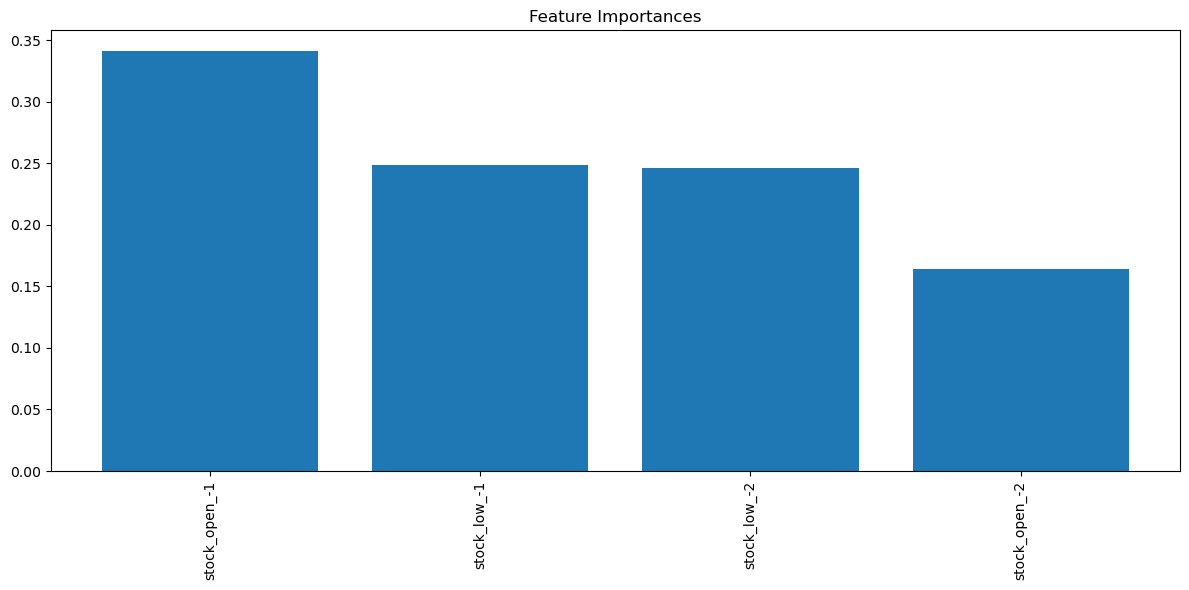

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = gbm.feature_importances_
# Sort indices by importance descending
indices = np.argsort(importances)[::-1]

# Sorted feature names and importances
sorted_features = [feature_cols[i] for i in indices]
sorted_importances = importances[indices]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")

# Plot bars in descending order
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')

# Set x-axis ticks and labels
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
# Prepare features for the entire DataFrame (fill missing values)
X_all = option_bars_df[feature_cols].fillna(0)

# Predict on all rows
option_bars_df['predicted_class'] = gbm.predict(X_all)

# Now option_bars_df has a new column with the predicted classes
option_bars_df


,tradingview_symbol,bid,ask,openInterest,implied_volatility,delta,gamma,theta,vega,open_0,close_0,volume_0,open_-1,close_-1,volume_-1,open_-2,close_-2,volume_-2,stock_open_0,stock_low_0,stock_open_-1,stock_low_-1,stock_open_-2,stock_low_-2,class,predicted_class
0,BLFY250718C10.0,0.00,0.00,4.0,0.000001,0.000000,0.000000,-0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.875000,9.800000,9.621000,9.621000,9.520000,9.520000,0,0
1,LINC250718C22.5,0.85,1.10,92.0,0.496786,0.554347,0.179349,-0.032693,0.017532,1.65,1.65,5.0,1.30,1.30,1.0,1.05,1.05,4.0,22.830000,22.360001,23.219999,21.049999,23.000000,22.780001,0,0
2,LINC250718P22.5,0.40,0.55,28.0,0.321438,-0.433493,0.275889,-0.018623,0.017450,0.75,0.75,1.0,0.40,0.40,1.0,0.50,0.50,2.0,22.830000,22.360001,23.219999,21.049999,23.000000,22.780001,0,0
3,AVO250718C12.5,0.05,0.25,172.0,0.343857,0.301776,0.430678,-0.010555,0.008207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.020000,11.930000,11.960000,11.890000,11.610000,11.570000,0,0
4,AVO250718P12.5,0.30,0.80,29.0,0.272817,-0.748649,0.496213,-0.006002,0.007502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.020000,11.930000,11.960000,11.890000,11.610000,11.570000,0,0
5,CSCO250711C69.0,0.84,0.88,0.0,0.316701,0.409513,0.129967,-0.086716,0.036695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.180000,68.180000,68.269459,67.772447,68.965276,68.229701,0,0
6,CSCO250711P69.0,0.49,0.53,556.0,NaN,NaN,NaN,NaN,NaN,0.83,0.51,551.0,0.98,1.13,167.0,0.75,0.81,218.0,68.180000,68.180000,68.269459,67.772447,68.965276,68.229701,0,0
7,VIRC250718C7.5,0.00,1.45,1.0,NaN,NaN,NaN,NaN,NaN,1.10,1.10,1.0,1.35,1.35,2.0,1.25,1.25,2.0,8.220000,8.220000,8.080000,8.050000,7.930000,7.910000,0,0
8,VIRC250718P7.5,0.00,0.25,52.0,0.634567,-0.204700,0.277547,-0.010122,0.004576,0.23,0.23,5.0,0.15,0.15,2.0,0.16,0.15,5.0,8.220000,8.220000,8.080000,8.050000,7.930000,7.910000,0,0
9,RGNX250718C7.5,0.15,4.70,0.0,2.906377,0.702807,0.070561,-0.061165,0.005845,1.20,1.20,5.0,1.40,1.40,1.0,1.10,1.10,11.0,8.630000,8.460000,8.230000,8.140000,8.100000,7.910000,0,0
